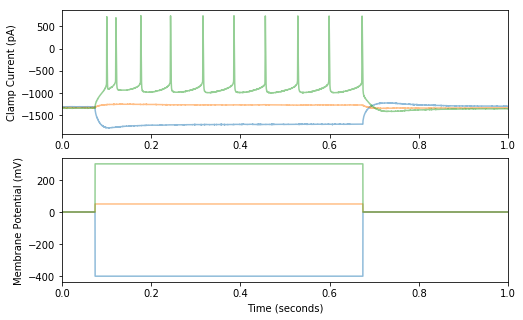

2020_03_02_0023.abf extracted


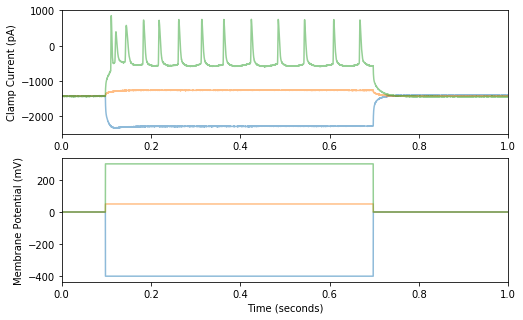

2020_07_07_0005.abf extracted


In [79]:
### Import statements
import pyabf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import os
from ipfx.sweep import Sweep, SweepSet
from ipfx.feature_extractor import SpikeTrainFeatureExtractor, SpikeFeatureExtractor
from ipfx.stimulus_protocol_analysis import LongSquareAnalysis
import pandas as pd

data_dict = {}
# refers to example_datasets folder in github repo
file_rel_path = 'examples/folder_name/' #INSERT DIRECTORY NAME HERE

for filename in os.listdir(file_rel_path):
    if filename.endswith('.abf'):
        curr_file = filename
        abf_file_path = file_rel_path + curr_file

        abf = pyabf.ABF(abf_file_path) # this is the basic function for accessing abf files

        ### Configuration variables
        stim_channel_num = 1 # on which channel number is the stimulus?
        response_chan_num = 0 # on which channel number is the response?

        stim_gain = 1 # integer gain on stimulus
        response_gain = 20 # integer gain on response

        stim_end = 1 # time point where stimulus ends

        sweep_plot_list = [0, 9, 14] # sweeps we want to plot
        fig = plt.figure(figsize=(8, 5))

        ### Figure plotting
        for i in sweep_plot_list:
            sweep_num = i

            # this setSweep command sets the currently active sweep in the file
            abf.setSweep(sweep_num, channel=response_chan_num)
            # plot the ADC (voltage recording)
            ax1 = fig.add_subplot(211)
            ax1.plot(abf.sweepX, abf.sweepY*response_gain, alpha = .5)

            # plot the DAC (clamp current)
            abf.setSweep(sweep_num, channel=stim_channel_num)
            ax2 = fig.add_subplot(212, sharex=ax1)  
            #abf.setSweep(sweep_num, channel=1)
            ax2.plot(abf.sweepX, abf.sweepC * stim_gain, alpha = .5)

        # decorate the plots
        ax1.set_ylabel(abf.sweepLabelY)
        ax2.set_xlabel(abf.sweepLabelX)
        ax2.set_ylabel(abf.sweepLabelC)
        ax1.axes.set_xlim(0, stim_end)  # <-- adjust axis like this
        plt.show()
        

        clamp_mode = "CurrentClamp" # set the clamp mode of the data as Current Clamp

        resp_sampling_rate = abf.dataRate # sampling rate in Hertz

        sweep_list = list() # initialize an empty list

        num_sweeps = abf.sweepCount # number of sweeps

        # iterate through all sweeps in file and create IPFX Sweep objects from each sweep,
        # a SweepSet is initialized from a list of Sweep objects
        for i in range(0, num_sweeps):
            sweep_num = i
            abf.setSweep(sweep_num, channel=response_chan_num)

            time_vec = abf.sweepX
            response_vec = abf.sweepY*response_gain


            abf.setSweep(sweep_num, channel=stim_channel_num)
            stim_vec = abf.sweepC * stim_gain


            sweep = Sweep(t=time_vec,
                          v=response_vec,
                          i=stim_vec,
                          sampling_rate=resp_sampling_rate,
                          sweep_number=i,
                          clamp_mode=clamp_mode,
                          #epochs = curr_epoch
                          )
            sweep_list.append(sweep)
        sweep_set = SweepSet(sweep_list) # this is the SweepSet object that has the data from the ABF file
        

        start_time = .2 # start time of stimulus
        end_time = 1 # end time of stimulus

        bessel_filter_khz = 1
        subthresh_min_amp = -500 # what minimum stimulus amplitude (in pA) to consider for analysis

        spike_extractor = SpikeFeatureExtractor(start=start_time, end=end_time, filter = bessel_filter_khz)
        spike_train_extractor = SpikeTrainFeatureExtractor(start=start_time, end=end_time, baseline_interval = .05)

        # Create the analysis object
        lsa = LongSquareAnalysis(spx=spike_extractor,
                                 sptx=spike_train_extractor,
                                 subthresh_min_amp= subthresh_min_amp 
                                )
        
        # We can analyze features using a single line below!
        lsa_results = lsa.analyze(sweep_set)

        # lsa_results has a lot of information that was extracted automatically!

        # let's now look at the data that was automatically extracted for the rheobase sweep
        lsa_results['rheobase_sweep']
        summarized_cell_features = summarize_cell_ephys_features(lsa_results)
        summarized_cell_features
        specimen_dict = summarized_cell_features
        data_dict[filename] = specimen_dict
        
        print("{} extracted".format(filename))
        
dfObj = pd.DataFrame(data_dict)
dfObj.to_csv('example_multi.csv') #INSERT SAVED CSV NAME HERE